In [ ]:
#hide
#all_slow

In [ ]:
# default_exp examples

# Examples

> Example workflows for using glycowork in your work

On this page, there are different toy examples demonstrating how you can apply `glycowork` to your projects! 
Here is a summary of the different case studies available: <br>

1. [Investigation of *N*-linked and *O*-linked glycosylations in animals](#example1)
2. [Glycan binding specificities of lectins](#example2)
3. [Glycan classification using machine learning models](#example3)
4. [Deep Learning Code Snippet](#example4)

In [ ]:
#hide
from nbdev.showdoc import *
from IPython.display import HTML
import pandas as pd
import copy
import warnings
warnings.filterwarnings("ignore")
from glycowork.glycan_data.loader import df_species, glycan_emb, glycan_binding, df_glycan
from glycowork.motif.analysis import plot_embeddings, make_heatmap, characterize_monosaccharide, get_pvals_motifs
from glycowork.motif.processing import presence_to_matrix
from glycowork.motif.query import get_insight
from glycowork.ml.model_training import train_ml_model, analyze_ml_model, get_mismatch
from glycowork.ml.train_test_split import general_split
%load_ext autoreload
%autoreload 2

# Example 1: Investigation of *N*-linked and *O*-linked glycosylations in arthropods <a class="anchor" id="example1"></a>

Suppose that after investigating glycans from plants as presented in the `core` module, you are now wondering how glycans from the Arthropoda phylum look like. To satisfy your curiosity, let's start with importing the `df_species` dataset from `glycowork.glycan_data.loader` and putting a filter for animal glycans.

In [ ]:
df_animal = df_species[df_species.Phylum == 'Arthropoda'].reset_index(drop = True)

In [ ]:
#hide_input
df_animal2 = copy.deepcopy(df_animal)
df_animal2.index = df_animal2.target.values.tolist()
df_animal2.drop(['target'], axis = 1, inplace = True)
HTML(df_animal2.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'}).render())

,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref
Gal(b1-3)GalNAc,Aedes_aegypti,Aedes,Culicidae,Diptera,Insecta,Arthropoda,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/2007124/
GalNAc(b1-4)GlcNAc(b1-2)ManOS(a1-6)[GlcNAc(b1-2)[GlcNAc(b1-4)]Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Aedes_aegypti,Aedes,Culicidae,Diptera,Insecta,Arthropoda,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/26047717/
GalNAc(bond)HexNAc(bond)GalNAc,Aedes_aegypti,Aedes,Culicidae,Diptera,Insecta,Arthropoda,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/26047717/
Glc(a1-3)Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Aedes_aegypti,Aedes,Culicidae,Diptera,Insecta,Arthropoda,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/12626419/
Glc(b1-3)[HexNAcOS(bond)]GalNAc,Aedes_aegypti,Aedes,Culicidae,Diptera,Insecta,Arthropoda,Animalia,Eukarya,https://pubmed.ncbi.nlm.nih.gov/26047717/


To have a better overview of the glycans similarities in arthropods, you can plot these data using `plot_embeddings` from `glycowork.motif.analysis`. The best option here, to visualize the data, is to color the dots by taxonomic class.  

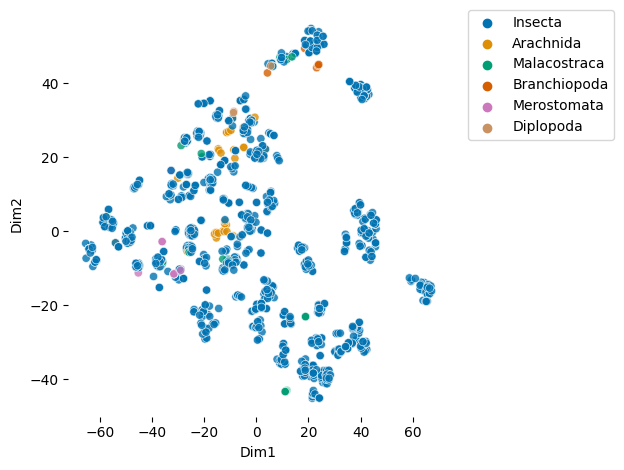

In [ ]:
plot_embeddings(df_animal.target.values.tolist(), label_list = df_animal.Class.values.tolist())

Interesting! First, the graph shows Arachnida clusters in addition to lots of Insecta clusters. <br> 

Now, let's focus on further analyses. We will first convert our data into a count table using `presence_to_matrix` from the `glycowork.motif.processing` module and then visualize the results. A heatmap can be generated using `make_heatmap` from `glycowork.motif.analysis`, and the `yticklabels = True` option allows us to display all the labels.

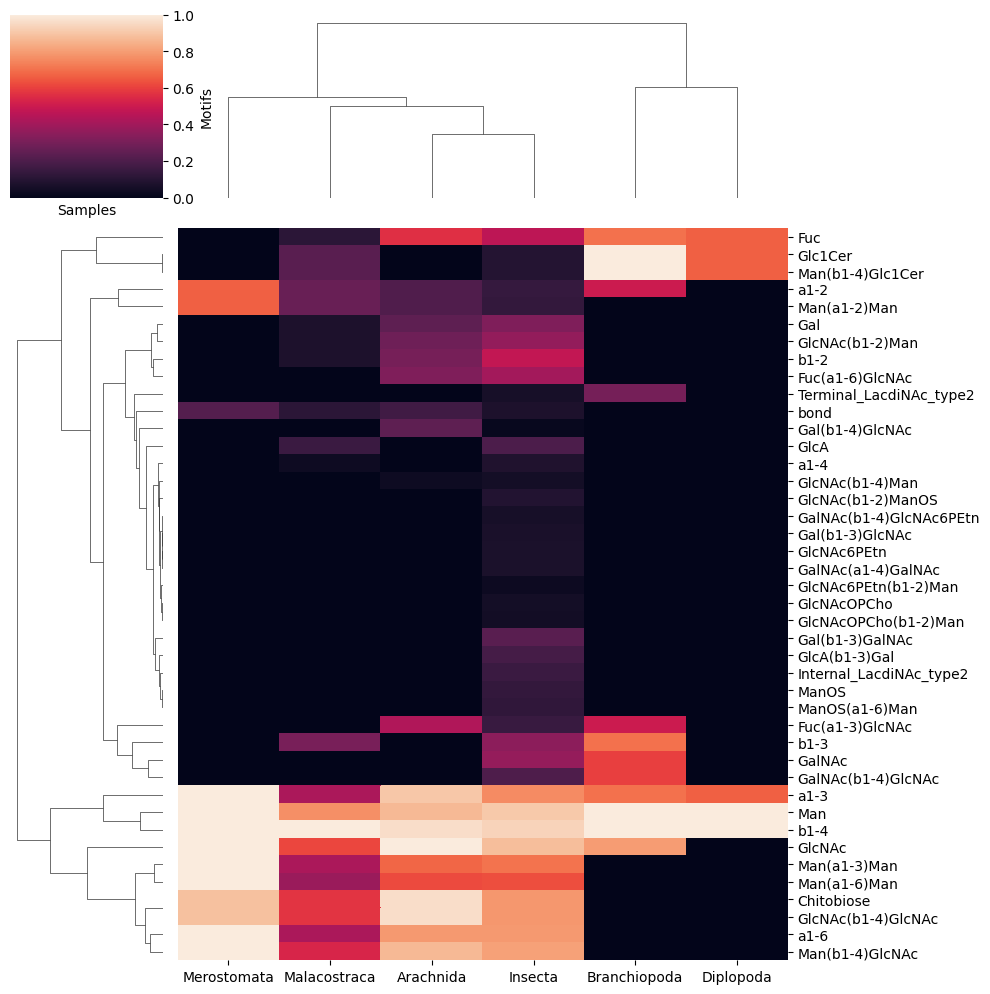

In [ ]:
df_map_animal = presence_to_matrix(df_animal, label_col_name = 'Class')
make_heatmap(df_map_animal, mode = 'motif', feature_set = ['known', 'exhaustive'], datatype = 'presence', yticklabels = True,
            estimate_speedup = True)

The first thing that catches the eye is the presence of a bunch of glycan motifs in Insecta that are absent in the other classes, in part presumably because of the scarcity of their known glycans relative to Insecta. Coming back to Arachnida, this heatmap shows for example a notable presence of difucosylated cores, with the corresponding distinguishing a1-3 Fuc motif. The other classes, Malacostraca and Merostomata, seem rather enriched in mannose-rich motifs in their *N*-glycans. <br>

To visualize which dots from the embedding plot correspond to, for instance, GlcA-containing glycans, we can map them again but with the additional option `shape_feature`. This parameter allows you to transform dots into crosses if the corresponding glycan contains the specified monosaccharide or linkage. 



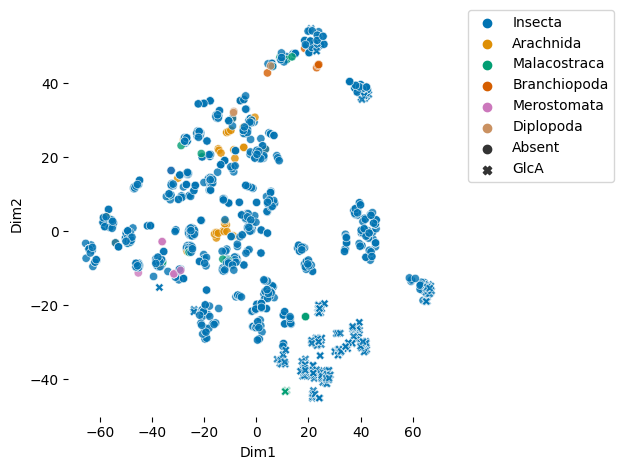

In [ ]:
plot_embeddings(df_animal.target.values.tolist(), label_list = df_animal.Class.values.tolist(), shape_feature = "GlcA")

As you can see, in `df_species`, GlcA-containing glycans (crosses) exist only in Insecta organisms (in the phylum Arthropoda). In this class, they even constitute isolated clusters, presumably corresponding to certain taxonomic groups. <br> 

We can also use `glycowork` to take a look at the overall monosaccharide distribution in animal glycans. The `characterize_monosaccharide` from `glycowork.motif.analysis` will be our best ally to learn what other monosaccharides, for instance, Gal variants are often connected to. <br>

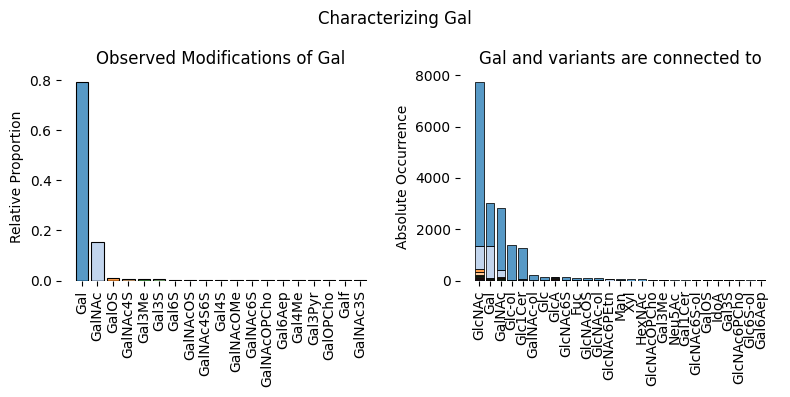

In [ ]:
characterize_monosaccharide('Gal', rank = 'Kingdom', focus = 'Animalia', modifications = True)

Running this analysis, it appears that Gal is found connected to GlcNAc as well as various other monosaccharides and that it does display several variants, including sulfurylated galactose. This is a completely different profile than we obtained for xylose in plant glycans! <br>

# Example 2: Glycan binding specificities of lectins <a class="anchor" id="example2"></a>

For this second example, we will focus on a specific set of proteins, called lectins, that bind glycans in a sequence-specific manner. One example for lectins can be found in the hemagglutinin protein of influenza virus. Influenza viruses are well known as the biological agents responsible for the seasonal flu in humans. In general, viruses penetrate inside host cells thanks to a mechanism involving contacts between proteins and glycans. Surface proteins surrounding viruses and eukaryotic cells interact together and allow the entry of viral particles inside the targeted cells. However, different influenza strains may recognize different glycosylations on proteins more or less efficiently. <br>

To measure these glycan binding specificities, one can add virus particles to glycan arrays presenting immobilized glycans. Such a protocol allows screening for specific binding. From such data, we can then ask what are the glycans that are the most efficiently recognized by a given influenza virus? <br>

Fortunately, `glycowork` can be really helpful to answer such a question! The binding specificity of 1,392 lectins for a vast range of glycans is available in the `glycan_binding` dataset. Let's start by importing these data.

In [ ]:
#hide_input
HTML(glycan_binding.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'}).render())

,3-Anhydro-Gal(a1-3)Gal(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal2S(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3dGal(b1-3)[Fuc(a1-4)]Glc,3dGal(b1-4)Glc,4d8dNeu5Ac(a2-3)Gal(b1-4)Glc,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,8dNeu5Ac(a2-3)Gal(b1-4)Glc,9dNeu5Ac(a2-3)Gal(b1-4)Glc,Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara,Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara,Fuc(a1-2)Gal,Fuc(a1-2)Gal(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal(a1-4)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-4)[Neu5Ac(a2-3)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-3)]Gal(b1-4)GlcNAc(b1-6)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc6S,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Fuc(a1-2)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)Glc6S,Fuc(a1-2)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)GalN

As you can see, this dataset contains numerical values (Z-scores) corresponding to the ability of different lectins to bind different glycans. From these data, we can compute a heatmap with `make_heatmap`. The results should teach us whether some specific strains bind specific glycans. As we work with quantitative values, the `datatype` parameter must be set to `'response'`. If you want to include literature-annotated motifs (e.g., VIM, Lewis X, Blood group A), just add 'known' to the list of the feature_set. Let's see what kind of heatmap we can generate using this dataset.

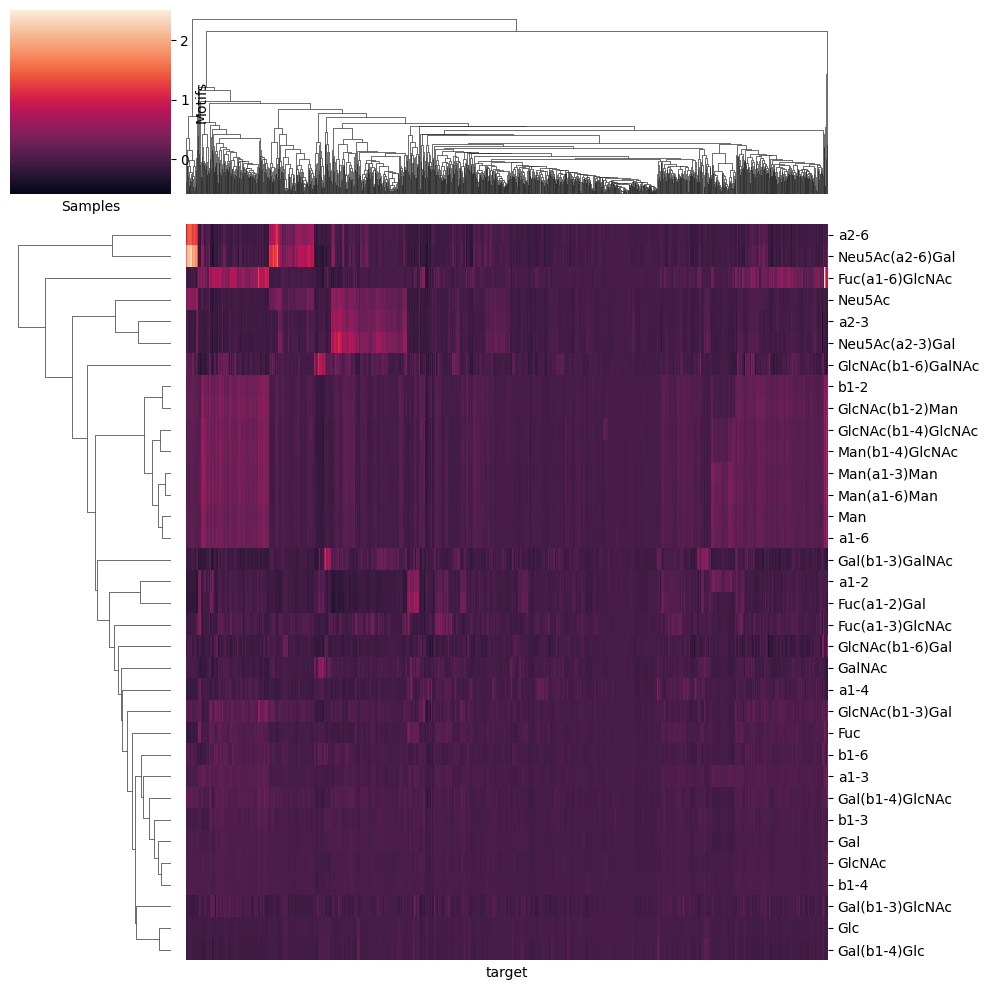

In [ ]:
make_heatmap(glycan_binding, mode = 'motif', feature_set = ['exhaustive'], datatype = 'response', yticklabels = 1,
            xticklabels = False)

In [ ]:
#hide_input
import numpy as np
glycan_binding = glycan_binding.clip(lower=0).replace(0,np.nan).dropna(thresh = 1, axis=1).dropna(thresh = 1, axis = 0)
glycan_binding.iloc[:,:-1] = glycan_binding.iloc[:,:-1].astype(np.float32)

Due to the high number of lectins in this dataset, the heatmap is difficult to analyze in detail. However, we can clearly see that there are clusters of lectins recognizing specific glycan motifs. Examples include Neu5Ac(a2-6)Gal, Neu5Ac(a2-3)Gal, Fuc(a1-6)GlcNAc, and others. All these represent well-known glycan motifs with important roles in biology. <br>

Another way to analyze the glycan binding capacities of lectins is to use the `get_pvals_motifs` function from the `glycowork.motif.analysis` module. As we are working with data obtained from different proteins, we must also set `multiple_samples` to `True`.

In [ ]:
results = get_pvals_motifs(glycan_binding, feature_set = ['exhaustive'], multiple_samples = True)

In [ ]:
#hide_input
results = results.applymap(str)
HTML(results[:25].style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica',
                                          'border-collapse': 'collapse','border': '1px solid black'}).render())

,motif,pval,corr_pval
58,b1-4,1.8105766142037072e-143,0.0
43,Neu5Ac,5.2714117926304566e-123,0.0
26,GlcNAc,1.980368513762096e-113,0.0
38,Man,2.8616948168475176e-107,0.0
205,Man(a1-3)Man,1.5247041217922468e-97,0.0
207,Man(a1-6)Man,8.114125848901856e-95,0.0
8,Gal,3.710533247731733e-91,0.0
215,Neu5Ac(a2-3)Gal,7.63292387136606e-85,0.0
183,GlcNAc(b1-4)GlcNAc,2.1665838781174787e-84,0.0
51,a1-6,2.6478638411565924e-79,0.0


These results indicate, for each motif, a p-value and a corrected p-value. These quantitative results support our qualitative observations from before. However, this represents a bird's eye view across all lectins in the dataset. A follow-up analysis might be to focus on a specific group of lectins, analyzing their binding patterns in depth.

# Example 3: Glycan classification using machine learning models <a class="anchor" id="example3"></a>

The investigation of glycans from animals and viruses demonstrated how specific their presence in an organism can be. This particular characteristic can be exploited to predict the source of a given glycan among organisms. By classifying which glycans stem from which species/taxonomic groups, machine learning models can be trained to learn which motifs are enriched in which species, allowing for further insights. <br>

Let's see how we can use `glycowork` to classify vertebrate versus invertebrate glycans! First, we need to annotate each known glycan using a binary code where **1** means **vertebrate glycan** and **0** means **invertebrate glycan**. 

In [ ]:
vertebrate = [1 if k == 'Chordata' else 0 for k in df_species[df_species.Kingdom == 'Animalia'].Phylum.values.tolist()]

Now, we have to generate two sets of glycans that we will use as train set and test set. In addition, we also need their corresponding sets with classes labelled as **0** or **1**. One way to do it is to use the `general_split` function from the `glycowork.ml.train_test_split` module. This function assigns the data with a 80/20 ratio to train and test sets respectively.

In [ ]:
X_train, X_test, y_train, y_test = general_split(df_species[df_species.Kingdom == 'Animalia'].target.values.tolist(), vertebrate)

It is now time to train a machine learning model on these data! Different machine learning algorithms are available in `glycowork` and here we can use the `train_ml_model` function from the `glycowork.ml.model_training` module. This classification method uses a standard machine learning model (XGBoost) trained on short glycan motifs which may not be the most accurate, but can be sufficient for a preliminary exploration of our problem. Plus, it has the advantage of running faster than other more complex algorithms such as deep learning so... let's give it a try!

In [ ]:
model_ft, _, X_test = train_ml_model(X_train, X_test, y_train, y_test, feature_calc = True, feature_set = ['exhaustive'],
                         return_features = True)


Calculating Glycan Features...

Training model...
[09:50:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Evaluating model...
Accuracy of trained model on separate validation set: 0.9150110375275938


As you can see, even this (quite) simple algorithm is enough to reach around 92% prediction accuracy on the test set! It also confirms that glycan composition is highly representative of their origin and allows efficiently discriminating vertebrate from invertebrate glycans. <br>

One more step we can do is the analysis of the model we have generated. This is important, as we do not know yet what information is the most useful for the model to predict the origin of a glycan. The `analyze_ml_model` function can help us to understand on which basis the model predictions are made.

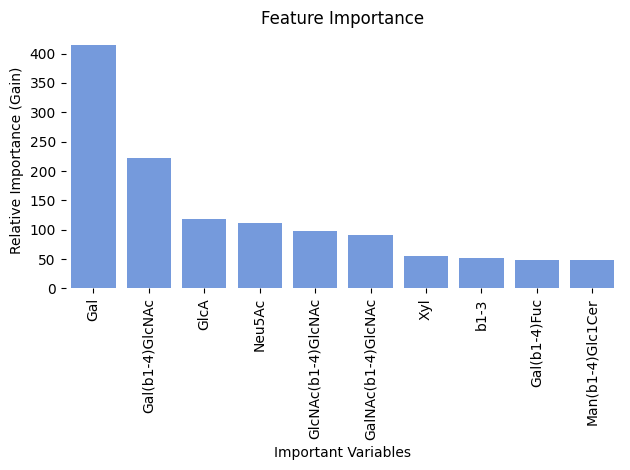

In [ ]:
analyze_ml_model(model_ft)

Interesting! It appears that the presence/absence of the Gal(b1-4)GlcNAc motif (type II LacNAc) and GlcA in glycans is quite discriminative of its belonging to the Chordata phylum or not! <br>

Next to knowing what is important for model prediction, it is often also crucial to know the limits of a model. In `glycowork`, you can use `get_mismatch` from the `glycowork.ml.model_training` module to get a sense of wrong classifications. This could for instance inform you about potential model biases.

In [ ]:
get_mismatch(model_ft, X_test, y_test)

[('GalNAc(b1-4)GlcNAc(b1-2)Man(a1-3)[GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.45373743772506714),
 ('GlcNAc(b1-2)[GlcNAc(b1-4)]Man(a1-3)[GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[FucOS(a1-6)]GlcNAc',
  0.7654131054878235),
 ('GlcNAc(b1-2)Man(a1-3)[GlcNAc(b1-2)[GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc',
  0.47539860010147095),
 ('Man(a1-6)Man(b1-4)GlcNAc(b1-4)GlcNAc', 0.4186375141143799),
 ('Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.4636443555355072),
 ('Man(a1-6)Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc', 0.3262776732444763),
 ('Fuc3S(a1-2)Fuc3S(a1-3)GlcA(b1-3)GalNAc6S', 0.5211899280548096),
 ('Xyl(bond)Glc', 0.28793126344680786),
 ('Man(b1-4)GlcNAc(b1-4)[Fuc(a1-3)][Fuc(a1-6)]GlcNAc-ol', 0.5379984378814697),
 ('Gal(bond)GlcNAc(b1-2)Man(a1-3)[Man(a1-3)[Man(a1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.8179002404212952)]

Here we can see that our model was especially confused by glycans which can occur in both phyla and therefore are ambiguous for classification ambiguous. Maybe in these scenarios a more powerful, deep learning-based model might be able to differentiate (at least a bit better)! <br>

# Deep Learning Code Snippet <a class="anchor" id="example4"></a>

For those of you that are blessed with GPU-access, we wrote up a minimal example for training a glycan-focused deep learning model. Even if you usually do not have access to a GPU, you can always go to Google Colab (click on the badge at the top of this site to open this notebook on Google Colab) and change the runtime type to GPU. Then you can paste the following code in a cell, execute, and see our model train!

First, we need to install torch_geometric for deep learning (keep the package versions; especially if you want to use our trained models):

```
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==2.0.2
```

Then, we import the relevant `glycowork` modules:

```
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import models
from glycowork.ml import model_training
```

Finally, we can prepare the data and train a model to classify from which taxonomic kingdom a glycan came from, using our graph convolutional neural network, `SweetNet`.

```
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_species,
                                                                                       rank = 'Kingdom')

dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)
model = models.prep_model('SweetNet', len(class_list))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005)
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100)
```

And that's it! You've just trained a state-of-the-art deep learning model with effectively five lines of code (excluding package imports of course).

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_alignment.ipynb.
Converted 02_glycan_data.ipynb.
Converted 03_ml.ipynb.
Converted 04_motif.ipynb.
Converted 05_examples.ipynb.
Converted 06_network.ipynb.
Converted index.ipynb.
